<a href="https://colab.research.google.com/github/cfparr/DAFX-AntiAliasing/blob/master/Granello_Parra_HW2_SASP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Put the files in your own Google Drive
from google.colab import drive
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
import math
from scipy import signal
import matplotlib.pyplot as plt
from scipy.io import wavfile
from math import ceil
from sklearn.cluster import KMeans
drive.mount('/content/drive')
filename_1 = '/content/drive/MyDrive/y1.wav'
filename_2 = '/content/drive/MyDrive/y2.wav'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[[1.0411398e+00 2.5861628e+00 2.4138248e+00 ... 2.4336956e+00
  6.7157543e-01 4.0496936e+00]
 [7.0641625e-01 2.6356525e+00 4.9386148e+00 ... 6.3674188e-01
  3.5351846e+00 5.1014533e+00]
 [5.1590002e-01 2.4160426e+00 5.5664282e+00 ... 4.0412575e-01
  5.2319908e+00 7.0224576e+00]
 ...
 [3.1424355e-04 1.2453833e-03 1.8422743e-03 ... 1.4556630e-03
  1.4293045e-03 1.0103162e-03]
 [2.7205935e-04 9.2197116e-04 8.5327716e-05 ... 1.9250590e-03
  4.8295123e-04 9.5534214e-04]
 [1.7081911e-04 7.0901425e-04 1.0296807e-03 ... 1.7472529e-03
  6.8797200e-04 7.7159551e-04]]


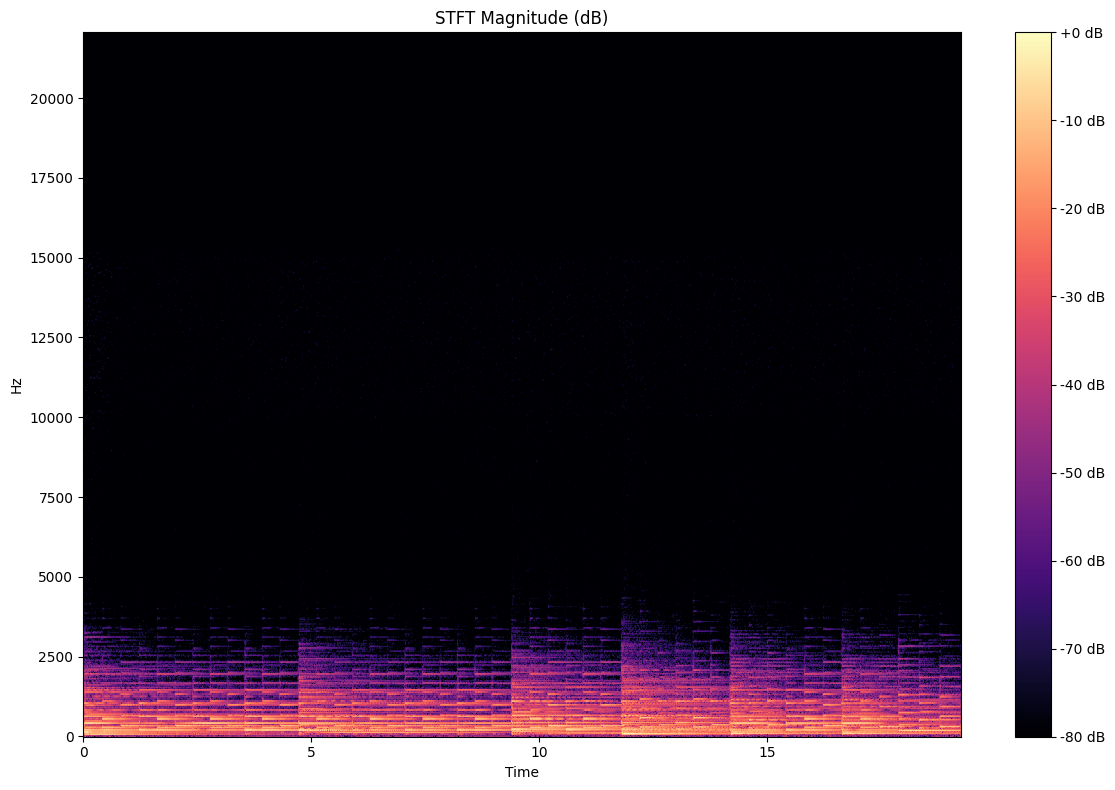

In [4]:
#####Librosa

# Load an audio file
audio, sr = librosa.load('piano.wav', sr=None)

# Calculate the STFT of the audio signal
n_fft = 2048
hop_length = 512
stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
#print (stft)
S = np.abs(stft)
print(S)
# Convert the STFT to decibels
stft_db = librosa.amplitude_to_db(abs(stft), ref=np.max)

# Plot the STFT
plt.figure(figsize=(12, 8))
librosa.display.specshow(stft_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz',fmax=10000)
plt.colorbar(format='%+2.0f dB')
plt.title('STFT Magnitude (dB)')
plt.tight_layout()
plt.show()


In [5]:
#STFT Functions
def get_bartlett(L):
    #coefficients for bartlett/triangular window.
    #L: Length of the window
    #window should have 50%
    half = 2* np.arange(L//2) / L
    return np.concatenate((half, np.flip(half)))
    
def get_windowed_signal(signal, L, R, w=None):
    """
    Partitions signal into windows of length M, separated by R samples
    returns: M x N matrix, where M is the window size, and N is number of windows
    """ 
    xms = np.array([np.zeros(L)]).T  # ini
    ws = w(L) if w is not None else None
    signal = np.concatenate([np.zeros(L//2), signal, np.zeros(L//2)])  # for COLA reconstruction
        # TODO: do we need to strip these zeros in istft?
    ms = range(0, len(signal), R)
    for m in ms:
        xm = signal[m:m+L].copy()
        if len(xm) < L:
            xm = np.concatenate([xm, np.zeros(L-len(xm))])
        if ws is not None:  # apply window fn
            xm *= ws
        xm = np.array([xm]).T
        xms = np.hstack([xms,xm])
    return xms[:, 1:]  # discard first column of all zeros 

def get_stft(windowed_signal, nfft=None):
    """
    :param windowed_signal: windowed signal matrix
    :param nfft: the size of the fft.
    
    :return 2-D matrix where each column is a single fft frame 
    """
    if nfft is None:
        nfft = windowed_signal.shape[0]
    ms = windowed_signal.shape[1]
    ffts = np.array([np.zeros(nfft)]).T
    for m in range(ms):
        xm = windowed_signal[:, m]
        freq_window = np.array([np.fft.fft(xm, nfft)]).T
        ffts = np.hstack([ffts, freq_window])
    return ffts[:, 1:]

    
def get_istft(stft, R):
    """ 
    Performs Overlap-Add reconstruction of original signal
    """
    nfft = stft.shape[0]  # size of the fft
    num_frames = stft.shape[1]  # number of fft windows
    signal = np.zeros((R * (num_frames - 1)) + nfft)
    for m in range(num_frames):
        idx = m*R
        windowed_signal = (np.fft.ifft(stft[:, m])).real
        signal[(idx):idx+nfft] += windowed_signal
    return signal #* (1/nfft)
#plot STFT


def plot_spectrogram(stft, fs, R, title="", colorbar=False):    
    """
    plot spectrogram of stft
    """
    plt.figure(figsize=[10,5])
    L = stft.shape[0]
    num_frames = stft.shape[1]
    # we only look at FFT freq up to nyquist limit fs/2, and normalize out imag components
    stft_db = 20*np.log10(np.abs(stft[:L//2, :])*2)
    plt_spec = plt.imshow(
        stft_db,
        origin='lower'
    )
    
    ## create ylim
    num_yticks = 10
    ks = np.linspace(0, L/2, num_yticks)
    ks_hz = ks * fs // (L)
    plt.yticks(ks,ks_hz)
    plt.ylabel("Frequency (Hz)")

    ## create xlim
    num_xticks = 10
    ts_spec = np.linspace(0, num_frames, num_xticks)
    ts_spec_sec  = ["{:4.2f}".format(i) for i in np.linspace(0, (R*num_frames)/fs, num_xticks)]
    plt.xticks(ts_spec,ts_spec_sec)
    plt.xlabel("Time (sec)")

    plt.title(f"{title} L={L} hopsize={R}, fs={fs} Spectrogram.shape={stft.shape}")
    if colorbar:
        plt.colorbar(None, use_gridspec=True)
    plt.show()
    return(plt_spec)

[[ 4.12108123e-01+0.00000000e+00j  2.15362918e+00+0.00000000e+00j
   1.77128983e+00+0.00000000e+00j ... -4.13621300e+00+0.00000000e+00j
   2.48622894e-03+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [-4.14857801e-01-5.89371315e-02j -1.17557472e+00-1.13808320e+00j
  -1.21864555e+00+1.20101087e+00j ... -8.89426226e-01+4.68187087e+00j
   2.48483547e-03-7.44421588e-05j  0.00000000e+00+0.00000000e+00j]
 [ 4.05321404e-01+1.36432699e-01j  1.50724548e+00+8.92128292e-01j
   4.92359966e+00-2.53065949e+00j ...  5.18938496e+00+3.19664556e+00j
   2.48065771e-03-1.48766526e-04j  0.00000000e+00+0.00000000e+00j]
 ...
 [-3.57552267e-01+2.15781441e-01j -1.88008858e+00+3.93914568e+00j
  -4.44304438e+00+2.10164296e+00j ...  6.22052646e+00+4.00216165e+00j
   2.47370360e-03+2.22855552e-04j  0.00000000e+00+0.00000000e+00j]
 [ 4.05321404e-01-1.36432699e-01j  1.50724548e+00-8.92128292e-01j
   4.92359966e+00+2.53065949e+00j ...  5.18938496e+00-3.19664556e+00j
   2.48065771e-03+1.48766526e-04j  0.00000000e+

<ipython-input-5-64cfa6ac0fdb>:70: RuntimeWarning: divide by zero encountered in log10
  stft_db = 20*np.log10(np.abs(stft[:L//2, :])*2)


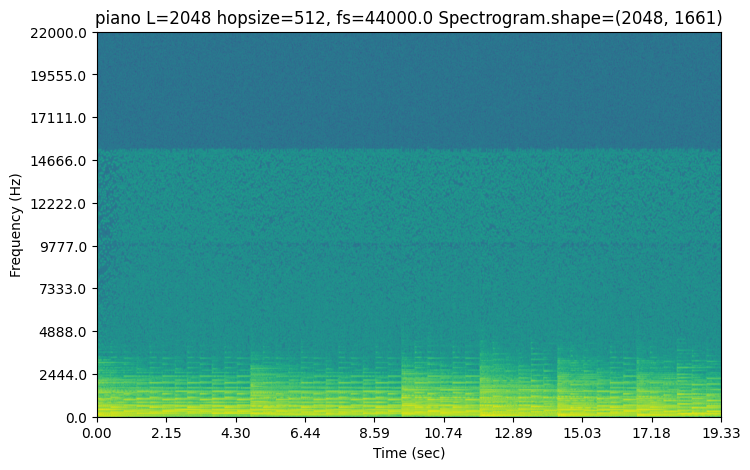

In [6]:
#plotting STFT using the created functions 

L = 1024  # window size
R = L // 2  # hop size  #Cola Condition
nfft = L*2  # convolution length of two length-L signals, the whitening filter and windowed signal
fs=44e3
w=get_bartlett
windowed_piano= get_windowed_signal(audio, L, R, w=w)
piano_STFT = get_stft(windowed_piano, nfft)
print (piano_STFT)
plot_spectrogram(piano_STFT, fs, R, title="piano")

In [7]:


##%% Join 2 wav files together
##Make sure all 3 wav files are the same length
##Pad all 3 wav files to the nearest second
#
##Read 2 wav files
#sample_rate1, samples1 = wavfile.read(filename_1)
#sample_rate2, samples2 = wavfile.read(filename_2)
#
##Find length of longest signal
#maxlength = max(len(samples1),len(samples1))
#
##Pad each signal to the length of the longest signal
#samples1 = np.pad(samples1, (0, maxlength - len(samples1)), 'constant', constant_values=(0))
#samples2 = np.pad(samples2, (0, maxlength - len(samples2)), 'constant', constant_values=(0))
#
##combine series together
#mixed_series = samples1 + samples2
#
##Pad 3 wav files to whole number of seconds
#extrapadding = (ceil(len(mixed_series) / sample_rate1) * sample_rate1) - len(mixed_series)
#mixed_series = np.pad(mixed_series, (0,extrapadding), 'constant', constant_values=(0))
#samples1 = np.pad(samples1, (0,extrapadding), 'constant', constant_values=(0))
#samples2 = np.pad(samples2, (0,extrapadding), 'constant', constant_values=(0))
#
##Create x axis of time
#x = np.arange(0, (len(mixed_series) / sample_rate1), (1 / sample_rate1))
#
##%% Compute the STFT of the 3 wav files
#
##Length of each segment. Defaults to 256. Set to 0.05 of a second
#nperseg = sample_rate1 / 50
#
##Get stft of 3 wav files
#f1, t1, Zsamples1 = signal.stft(samples1, fs=sample_rate1, nperseg=nperseg)
#f2, t2, Zsamples2 = signal.stft(samples2, fs=sample_rate1, nperseg=nperseg)
#fmixed, tmixed, Zmixed_series = signal.stft(mixed_series, fs=sample_rate1, nperseg=nperseg)
#
##%% Create mask and apply it to the signal
## Create IBM for signal 1 by calculating SNR of signal 1 vs mixture signal
#
##Choose sample to create mask for
#Zsample = Zsamples2
#sample = samples2
#
##Calculate signal to noise ratio of clean signal versus combined signal
#snr = np.divide(np.real(np.abs(Zsample)), np.real(np.abs(Zmixed_series)))
##round snr to 0 or 1 to create binary mask
#mask = np.around(snr, 0)
#
##convert all nan in mask to 1 (it shouldnt matter if this is 0 or 1)
#mask[np.isnan(mask)] = 1
# 
##replace all values over 1 with 1
#mask[mask > 1] = 1
#     
##check to see what maximum value in array is     
#np.amax(mask)
#
##Element-wise multiply mask with mixed signal t-f signal
#Zsamplesmaked = np.multiply(Zmixed_series, mask)
#
##%% Show mask
#fig = plt.figure() 
#plt.imshow(mask, cmap='Greys', interpolation='none')
#
#fig.savefig( "mask.png", bbox_inches="tight")
#plt.show()
#plt.close(fig)
#
##%% convert back to a time series via inverse STFT
#_, samplesrec = signal.istft(Zsamplesmaked, sample_rate1)

In [85]:
#Getting the STFT of both signals y_1 and y_2

fs_y_1, y_1 = wavfile.read(filename_1)
fs_y_2, y_2 = wavfile.read(filename_2)
L = 1024  # window size
R = L // 2  # hop size  #Cola Condition
nfft = L*2  # convolution length of two length-L signals, the whitening filter and windowed signal
fs=8e3
w=get_bartlett
#Signal Y1
windowed_Y_1= get_windowed_signal(y_1, L, R, w=w)
Y_1_STFT = get_stft(windowed_Y_1, nfft)
#Signal Y2
windowed_Y_2= get_windowed_signal(y_2, L, R, w=w)
Y_2_STFT = get_stft(windowed_Y_2, nfft)


In [80]:
print(fs_y_1)

8000


In [86]:
#Extracting the feature vector
#Φ(𝑚,𝜔_𝑘)=[𝐴_1(𝑚,𝜔_𝑘),𝐴2(𝑚,𝜔𝑘),𝑃(𝑚,𝜔𝑘)]^T,
Y_1_abs= np.abs(Y_1_STFT)
Y_2_abs= np.abs(Y_2_STFT)
Y_1_pha=np.angle (Y_1_STFT)
Y_2_pha=np.angle (Y_2_STFT)
A_1 = np.zeros((Y_1_abs.shape[0], Y_1_abs.shape[1]))
A_2 = np.zeros((Y_2_abs.shape[0], Y_2_abs.shape[1]))
P = np.zeros((Y_2_abs.shape[0], Y_2_abs.shape[1]))
EPS = 1e-9  # small constant to avoid dividing by zero
for i in range(Y_1_abs.shape[0]):
    for j in range(Y_1_abs.shape[1]):
        A_1[i,j] = Y_1_abs[i,j]/(math.sqrt((Y_1_abs[i,j])**2+(Y_2_abs[i,j])**2 + EPS))
        A_2[i,j] = Y_2_abs[i,j]/(math.sqrt((Y_1_abs[i,j])**2+(Y_2_abs[i,j])**2 + EPS))
        P[i,j]= (1/2*math.pi)* Y_2_pha[i,j]/(Y_1_pha[i,j] + EPS)
#Feature Vector
Phi = np.zeros((159, 3, 2048))
Phi[:, 0, :] = A_1.T
Phi[:, 1, :] = A_2.T
Phi[:, 2, :] = P.T


In [79]:
#Clustering

#Phi = np.nan_to_num(Phi, nan=0)
kmeans = KMeans(n_clusters=3).fit(Phi)

# get the cluster labels
cluster_labels = kmeans.labels_
print(cluster_labels)


ValueError: ignored

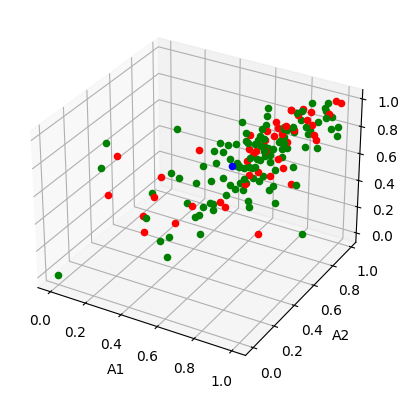

In [28]:
#Plotting clustering

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Assuming "cluster_labels" contains the labels of the clusters assigned by KMeans
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b']  # Define colors for each cluster

# Plot points colored by cluster
for i in range(len(cluster_labels)):
    ax.scatter(Phi[i, 0], Phi[i, 1], Phi[i, 2], c=colors[cluster_labels[i]], marker='o')

ax.set_xlabel('A1')
ax.set_ylabel('A2')
ax.set_zlabel('P')
plt.show()


In [41]:

#Creating binary mask

desired_cluster = 0

# create binary mask M_0 based on cluster labels
M_0 = np.zeros_like(Phi)
for m in range(M_0.shape[0]):
        cluster_index = cluster_labels[m]
        if cluster_index == desired_cluster:
            M_0[m, :] = 1

desired_cluster = 1
# create binary mask M_1 based on cluster labels
M_1 = np.zeros_like(Phi)
for m in range(M_1.shape[0]):
        cluster_index = cluster_labels[m]
        if cluster_index == desired_cluster:
            M_1[m, :] = 1

desired_cluster = 2
# create binary mask M_2 based on cluster labels
M_2 = np.zeros_like(Phi)
for m in range(M_2.shape[0]):
        cluster_index = cluster_labels[m]
        if cluster_index == desired_cluster:
            M_2[m, :] = 1




[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [46]:
print(M_0)
print(M_1)
print (M_2)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
[[1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [56]:
Estimated_1 = M_0 * Y_1_STFT.T


ValueError: ignored